# AutoML Regression


<img src='https://github.com/retkowsky/images/blob/master/AzureMLservicebanniere.png?raw=true'>

In [76]:
import sys
print("Version Python : ", sys.version)

Version Python :  3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) 
[GCC 7.3.0]


In [77]:
import datetime
now = datetime.datetime.now()
print(now)

2019-11-22 10:06:16.244807


In [78]:
import azureml.core
print("Version Azure ML service :", azureml.core.VERSION)

Version Azure ML service : 1.0.74


## 1. Création expérimentation

As part of the setup you have already created an Azure ML `Workspace` object. For AutoML you will need to create an `Experiment` object, which is a named object in a `Workspace` used to run experiments.

In [79]:
import logging
import os
import random

from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np
import pandas as pd
from sklearn import datasets

import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.train.automl import AutoMLConfig
from azureml.train.automl.run import AutoMLRun

In [80]:
ws = Workspace.from_config()

# Choose a name for the experiment and specify the project folder.
experiment_name = 'workshop3'
project_folder = './sample_projects/workshop3'

experiment = Experiment(ws, experiment_name)

output = {}
output['SDK version'] = azureml.core.VERSION
output['Workspace Name'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Project Directory'] = project_folder
output['Experiment Name'] = experiment.name
pd.set_option('display.max_colwidth', -1)
pd.DataFrame(data = output, index = ['']).T

,
SDK version,1.0.74
Workspace Name,workshopml
Resource Group,workshopmlRG
Location,northeurope
Project Directory,./sample_projects/workshop3
Experiment Name,workshop3


## 2. Chargement des données

This uses scikit-learn's [load_diabetes](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html) method.

In [81]:
# Load the diabetes dataset, a well-known built-in small dataset that comes with scikit-learn.
from sklearn.datasets import load_diabetes
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

X, y = load_diabetes(return_X_y = True)

columns = ['age', 'gender', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

## 3. Configuration AutoML


In [82]:
automl_config = AutoMLConfig(task = 'regression',
                             iteration_timeout_minutes = 2, #Temps max par itération
                             experiment_timeout_minutes = 5, #Temps max pour l'automl
                             enable_early_stopping=True, # critère de sortie si pas d'amélioration de la métrique
                             primary_metric = 'spearman_correlation', #métrique
                             n_cross_validations = 5, #nombre de validation croisées
                             debug_log = 'automl.log',
                             verbosity = logging.INFO,
                             X = X_train, 
                             y = y_train,
                             path = project_folder)

WARNING - The AutoMLConfig inputs you have specified will soon be deprecated. Please use the AutoMLConfig shown in our documentation: https://aka.ms/AutoMLConfig


## 4. AutoML

Call the `submit` method on the experiment object and pass the run configuration. Execution of local runs is synchronous. Depending on the data and the number of iterations this can run for a while.
In this example, we specify `show_output = True` to print currently running iterations to the console.

`spearman_correlation` is the metric used.

In [83]:
%%time
local_run = experiment.submit(automl_config, show_output = True)

Running on local machine
Parent Run ID: AutoML_a4cf0cb0-e35c-4907-ae54-b5ee3d7f8137
Current status: DatasetCrossValidationSplit. Generating CV splits.
Current status: ModelSelection. Beginning model selection.

****************************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summary description of the pipeline being evaluated.
DURATION: Time taken for the current iteration.
METRIC: The result of computing score on the fitted pipeline.
BEST: The best observed score thus far.
****************************************************************************************************

 ITERATION   PIPELINE                                       DURATION      METRIC      BEST
         0   StandardScalerWrapper RandomForest             0:00:12       0.7000    0.7000
         1   MinMaxScaler RandomForest                      0:00:13       0.6805    0.7000
         2   StandardScalerWrapper ExtremeRandomTrees   

In [84]:
local_run

Experiment,Id,Type,Status,Details Page,Docs Page
workshop3,AutoML_a4cf0cb0-e35c-4907-ae54-b5ee3d7f8137,automl,Running,Link to Azure Machine Learning studio,Link to Documentation


In [85]:
from azureml.widgets import RunDetails
RunDetails(local_run).show() 

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

## Autre AutoML

> Avec cette fois un changement de métrique, ajout d'une whiteliste, compatibilité ONNX, pas de méthodes ensembles et un score de sortie et 20 itérations au max.
https://docs.microsoft.com/en-us/python/api/azureml-train-automl/azureml.train.automl.automlconfig?view=azure-ml-py

In [88]:
automl_config = AutoMLConfig(task = 'regression',
                             iteration_timeout_minutes = 5,
                             iterations = 10, # nombre itérations au max
                             primary_metric = 'spearman_correlation',
                             n_cross_validations = 5,
                             debug_log = 'automl2.log',
                             verbosity = logging.INFO,
                             whitelist_models = ["LightGBM", "RandomForest"], # Whiteliste de modèles à évaluer
                             experiment_exit_score = 0.7, # Score de sortie de la métrique
                             enable_onnx_compatible_models=True, # Modèles compatibles ONNX
                             enable_stack_ensemble=False, # Pas de méthode stack ensemble
                             enable_voting_ensemble=False, # Pase de méthode vote ensemble
                             X = X_train, 
                             y = y_train,
                             path = project_folder)

WARNING - The AutoMLConfig inputs you have specified will soon be deprecated. Please use the AutoMLConfig shown in our documentation: https://aka.ms/AutoMLConfig


In [89]:
%%time
local_run = experiment.submit(automl_config, show_output = True)

Running on local machine
Parent Run ID: AutoML_d7c65858-b7c5-4a35-8b93-1cb0591df736
Current status: DatasetCrossValidationSplit. Generating CV splits.
Current status: ModelSelection. Beginning model selection.

****************************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summary description of the pipeline being evaluated.
DURATION: Time taken for the current iteration.
METRIC: The result of computing score on the fitted pipeline.
BEST: The best observed score thus far.
****************************************************************************************************

 ITERATION   PIPELINE                                       DURATION      METRIC      BEST
         0   StandardScalerWrapper RandomForest             0:00:13       0.6988    0.6988
         1   MinMaxScaler RandomForest                      0:00:13       0.6750    0.6988
         2   StandardScalerWrapper LightGBM             

In [90]:
local_run

Experiment,Id,Type,Status,Details Page,Docs Page
workshop3,AutoML_d7c65858-b7c5-4a35-8b93-1cb0591df736,automl,Running,Link to Azure Machine Learning studio,Link to Documentation


## 5. Exploration des résultats

### 5.1 Widget Notebook

The widget will first report a "loading" status while running the first iteration. After completing the first iteration, an auto-updating graph and table will be shown. The widget will refresh once per minute, so you should see the graph update as child runs complete.

**Note:** The widget displays a link at the bottom. Use this link to open a web interface to explore the individual run details.

In [91]:
from azureml.widgets import RunDetails
RunDetails(local_run).show() 

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…


### 5.2 Récupération de toutes les itérations

In [92]:
children = list(local_run.get_children())
metricslist = {}
for run in children:
    properties = run.get_properties()
    metrics = {k: v for k, v in run.get_metrics().items() if isinstance(v, float)}
    metricslist[int(properties['iteration'])] = metrics

rundata = pd.DataFrame(metricslist).sort_index(1)
rundata

,0,1,2,3,4
explained_variance,0.50,0.49,0.49,0.45,0.52
mean_absolute_error,46.06,45.81,46.27,46.07,45.22
mean_absolute_percentage_error,41.98,41.24,42.15,39.96,40.59
median_absolute_error,42.03,40.48,40.70,39.72,42.29
normalized_mean_absolute_error,0.14,0.14,0.14,0.14,0.14
normalized_median_absolute_error,0.13,0.13,0.13,0.12,0.13
normalized_root_mean_squared_error,0.17,0.18,0.18,0.18,0.17
normalized_root_mean_squared_log_error,0.17,0.17,0.17,0.17,0.16
r2_score,0.48,0.47,0.47,0.43,0.50
root_mean_squared_error,55.61,56.44,56.22,58.35,54.84


### 5.3 Obtention du meilleur modèle

Below we select the best pipeline from our iterations. The `get_output` method returns the best run and the fitted model. The Model includes the pipeline and any pre-processing.  Overloads on `get_output` allow you to retrieve the best run and fitted model for *any* logged metric or for a particular *iteration*.

In [93]:
best_run, fitted_model = local_run.get_output()
print(best_run)
print(fitted_model)

Run(Experiment: workshop3,
Id: AutoML_d7c65858-b7c5-4a35-8b93-1cb0591df736_4,
Type: None,
Status: Completed)
RegressionPipeline(pipeline=Pipeline(memory=None,
     steps=[('StandardScalerWrapper', <automl.client.core.runtime.model_wrappers.StandardScalerWrapper object at 0x7f3e144a7358>), ('RandomForestRegressor', RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity...timators=25, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]),
          stddev=None)


In [94]:
fitted_model.get_params

<bound method Pipeline.get_params of RegressionPipeline(pipeline=Pipeline(memory=None,
     steps=[('StandardScalerWrapper', <automl.client.core.runtime.model_wrappers.StandardScalerWrapper object at 0x7f3e144a7358>), ('RandomForestRegressor', RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity...timators=25, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]),
          stddev=None)>

In [95]:
fitted_model.steps

[('StandardScalerWrapper',
  <automl.client.core.runtime.model_wrappers.StandardScalerWrapper at 0x7f3e144a7358>),
 ('RandomForestRegressor',
  RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=0.02840067375118317,
             min_samples_split=0.0008991789964660114,
             min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=1,
             oob_score=False, random_state=None, verbose=0, warm_start=False))]

### 5.4 Changement de métrique
Show the run and the model that has the smallest `root_mean_squared_error` value (which turned out to be the same as the one with largest `spearman_correlation` value):

In [96]:
lookup_metric = "root_mean_squared_error"
best_run, fitted_model = local_run.get_output(metric = lookup_metric)
print(best_run)
print(fitted_model)

Run(Experiment: workshop3,
Id: AutoML_d7c65858-b7c5-4a35-8b93-1cb0591df736_4,
Type: None,
Status: Completed)
RegressionPipeline(pipeline=Pipeline(memory=None,
     steps=[('StandardScalerWrapper', <automl.client.core.runtime.model_wrappers.StandardScalerWrapper object at 0x7f3dfc6fc9e8>), ('RandomForestRegressor', RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity...timators=25, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]),
          stddev=None)


### 5.5 Choix d'une itération spécifique
Show the run and the model from the third iteration:

In [97]:
iteration = 3
ite_run, ite_model = local_run.get_output(iteration = iteration)
print(ite_run)
print(ite_model)

Run(Experiment: workshop3,
Id: AutoML_d7c65858-b7c5-4a35-8b93-1cb0591df736_3,
Type: None,
Status: Completed)
RegressionPipeline(pipeline=Pipeline(memory=None,
     steps=[('StandardScalerWrapper', <automl.client.core.runtime.model_wrappers.StandardScalerWrapper object at 0x7f3dfc70bf28>), ('LightGBMRegressor', LightGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1,
         importance_type='split', learning_rate=0.1052678947368421,
     ...nt=True,
         subsample=0.65, subsample_for_bin=200000, subsample_freq=1,
         verbose=-1))]),
          stddev=None)


## 6. Validation

Predict on training and test set, and calculate residual values.

In [98]:
y_pred_train = fitted_model.predict(X_train)
y_residual_train = y_train - y_pred_train

y_pred_test = fitted_model.predict(X_test)
y_residual_test = y_test - y_pred_test

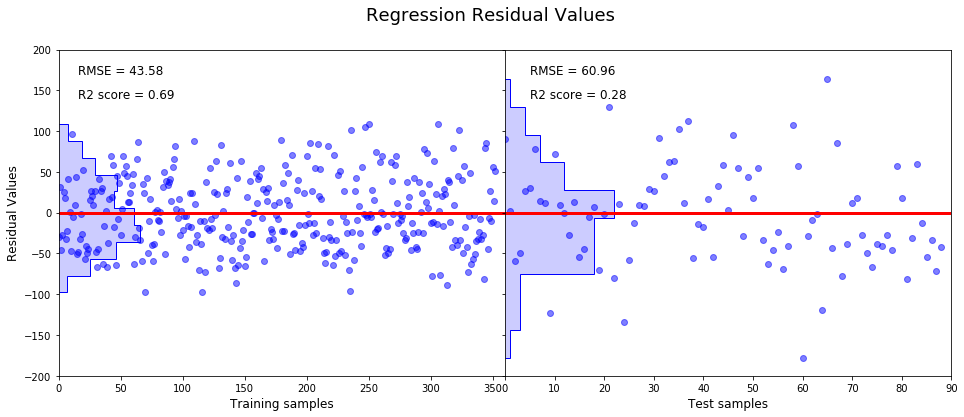

In [99]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn.metrics import mean_squared_error, r2_score

# Set up a multi-plot chart.
f, (a0, a1) = plt.subplots(1, 2, gridspec_kw = {'width_ratios':[1, 1], 'wspace':0, 'hspace': 0})
f.suptitle('Regression Residual Values', fontsize = 18)
f.set_figheight(6)
f.set_figwidth(16)

# Plot residual values of training set.
a0.axis([0, 360, -200, 200])
a0.plot(y_residual_train, 'bo', alpha = 0.5)
a0.plot([-10,360],[0,0], 'r-', lw = 3)
a0.text(16,170,'RMSE = {0:.2f}'.format(np.sqrt(mean_squared_error(y_train, y_pred_train))), fontsize = 12)
a0.text(16,140,'R2 score = {0:.2f}'.format(r2_score(y_train, y_pred_train)), fontsize = 12)
a0.set_xlabel('Training samples', fontsize = 12)
a0.set_ylabel('Residual Values', fontsize = 12)

# Plot a histogram.
a0.hist(y_residual_train, orientation = 'horizontal', color = 'b', bins = 10, histtype = 'step');
a0.hist(y_residual_train, orientation = 'horizontal', color = 'b', alpha = 0.2, bins = 10);

# Plot residual values of test set.
a1.axis([0, 90, -200, 200])
a1.plot(y_residual_test, 'bo', alpha = 0.5)
a1.plot([-10,360],[0,0], 'r-', lw = 3)
a1.text(5,170,'RMSE = {0:.2f}'.format(np.sqrt(mean_squared_error(y_test, y_pred_test))), fontsize = 12)
a1.text(5,140,'R2 score = {0:.2f}'.format(r2_score(y_test, y_pred_test)), fontsize = 12)
a1.set_xlabel('Test samples', fontsize = 12)
a1.set_yticklabels([])

# Plot a histogram.
a1.hist(y_residual_test, orientation = 'horizontal', color = 'b', bins = 10, histtype = 'step')
a1.hist(y_residual_test, orientation = 'horizontal', color = 'b', alpha = 0.2, bins = 10)

plt.show()

> Plus d'information : https://docs.microsoft.com/en-us/azure/machine-learning/service/

<img src="https://github.com/retkowsky/images/blob/master/Powered-by-MS-Azure-logo-v2.png?raw=true" height="300" width="300">